In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from torch.utils.data import TensorDataset
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA

In [3]:
class Trainer:

    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: None,
                 # lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False,
                 path2write: str = None,
                 save_best=False,
                 save_final=True,
                 save_interval=10,
                 checkpoint_start_epoch=50
                 ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        # self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        self.path2write = path2write
        LOG_DIR = os.path.join(path2write, 'Log')  # path2write + 'Log/'
        self.writer_train = SummaryWriter(os.path.join(LOG_DIR, "train"))
        self.writer_val = SummaryWriter(os.path.join(LOG_DIR, "val"))
        self.check_point_path = os.path.join(path2write, 'check_points')
        if not os.path.exists(self.check_point_path):
            os.makedirs(self.check_point_path)
        self.save_best = save_best
        self.save_final = save_final
        self.save_interval = save_interval
        self.checkpoint_start_epoch = checkpoint_start_epoch
        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []
        self.training_accuracy = []
        self.validation_accuracy = []

    def run_trainer(self):
        self.model.to(self.device)
        #         print(next(self.model.parameters()).device)
        if self.notebook:
            print('Notebook')
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange
        #         print(self.epochs)
        progressbar = trange(self.epochs, desc='Progress', disable=True)  # don't show progressbar
        loss_max = None
        for epoch in progressbar:
            print(f'Epoch - {epoch}')

            # Training Block
            train_loss, train_accuracy = self._train()
            self.writer_train.add_scalar("Train Loss", train_loss, epoch)
            self.writer_train.add_scalar("Train Accuracy", train_accuracy, epoch)


            # Val Block
            val_loss, val_accuracy = self._validate()
            self.writer_val.add_scalar("Val Loss", val_loss, epoch)
            self.writer_val.add_scalar("Val Accuracy", val_accuracy, epoch)

            # lr
            self.writer_train.add_scalar("Learning Rate", self.optimizer.param_groups[0]['lr'], epoch)

            print('Epoch - {} Train Loss - {:.6f} Val Loss - {:.6f} Train Accuracy - {:.6f} Val Accuracy - {:.6f}'.format(epoch, train_loss, val_loss, train_accuracy, val_accuracy))
            if self.save_final:
                if epoch == self.epochs-1:
                    model_name = 'epoch-{}-loss{:.6f}'.format(epoch, val_loss)
                    torch.save(self.model.state_dict(), os.path.join(self.check_point_path, model_name))
            loss_max = val_loss

        return self.training_loss, self.validation_loss, self.model, self.training_accuracy, self.validation_accuracy

    def _train(self):

        self.model.train()
        train_losses = []
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          disable=False)
        batch_acc = 0
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.type(torch.float32).to(self.device)
            self.optimizer.zero_grad()
            target = target.type(torch.LongTensor).to(self.device)
            output = self.model(input)
            loss = self.criterion(output, target)
            train_losses.append(loss.item())
            loss.backward()
            self.optimizer.step()
            pred = output.argmax(dim=1, keepdim=True) # max of prob
            pred = pred.flatten()
            batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor))
        accuracy = batch_acc/len(self.training_DataLoader)
        self.training_loss.append(np.mean(train_losses))  # Mean batch loss
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])
        self.training_accuracy.append(accuracy)

        batch_iter.close()  # clean up the bar
        return np.mean(train_losses), accuracy

    def _validate(self):

        self.model.eval()
        valid_losses = []
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'validation', total=len(self.validation_DataLoader), disable=False)
        batch_acc = 0
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.to(self.device)
            with torch.no_grad():
                output = self.model(input)
                target = target.type(torch.LongTensor).to(self.device)
                loss = self.criterion(output, target)
                valid_losses.append(loss.item())
                pred = output.argmax(dim=1, keepdim=True)
                batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor)).item()

        accuracy = batch_acc/len(self.validation_DataLoader)
        self.validation_loss.append(np.mean(valid_losses))
        self.validation_accuracy.append(accuracy)
        batch_iter.close()
        return np.mean(valid_losses), accuracy

In [4]:
class DNN(nn.Module): #for mnist
  def __init__(self):
    super().__init__()
    self.Dense1 = nn.Linear(28*28, 64)
    self.Dense2 = nn.Linear(64, 32)
    self.Dense3 = nn.Linear(32, 16)
    self.Dense4 = nn.Linear(16, 10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.Dense1(x)
    x = self.Dense2(x)
    x = self.Dense3(x)
    x = self.Dense4(x)
    out = F.log_softmax(x)

    return out

In [5]:
path2write = os.path.expanduser("~/my_logs")  # This will create a 'my_logs' directory in your home directory


In [6]:
gpu_id = 0
loss_fn = nn.CrossEntropyLoss()
epochs =  20
notebook = True
checkpoint_start_epoch = 5 #Not using
path2write = "drive/MyDrive/DL_homework/HW1_1/"

In [7]:
bath_size = 256
lr = 1e-4

transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('Home work', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('Home work', train=False, transform=transform)
training_DataLoader = DataLoader(dataset1, batch_size=bath_size, shuffle=True)
validation_DataLoader= DataLoader(dataset2, batch_size=bath_size, shuffle=True)


model = DNN()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
trainer = Trainer(model=model,
                        device=gpu_id,
                        criterion=loss_fn,
                        optimizer=optimizer,
                        training_DataLoader=training_DataLoader,
                        validation_DataLoader=validation_DataLoader,
                        # lr_scheduler=lr_scheduler,
                        epochs=epochs,
                        epoch=0,
                        notebook=True,
                        path2write= path2write,
                        checkpoint_start_epoch=checkpoint_start_epoch )
training_loss_lr1e4_B256, validation_loss_lr1e4_B256, model_lr1e4_B256, training_accuracy_lr1e4_B256, validation_accuracy_lr1e4_B256 = trainer.run_trainer()



Notebook
Epoch - 0


Training:   0%|          | 0/235 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_656613/2850139075.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 40/40 [00:00<00:00, 56.86it/s]


Epoch - 0 Train Loss - 1.836728 Val Loss - 1.222279 Train Accuracy - 0.469997 Val Accuracy - 0.681934
Epoch - 1


validation: 100%|██████████| 40/40 [00:00<00:00, 57.08it/s]


Epoch - 1 Train Loss - 0.907117 Val Loss - 0.687595 Train Accuracy - 0.752504 Val Accuracy - 0.805176
Epoch - 2


validation: 100%|██████████| 40/40 [00:00<00:00, 56.84it/s]


Epoch - 2 Train Loss - 0.621194 Val Loss - 0.548178 Train Accuracy - 0.821077 Val Accuracy - 0.840723
Epoch - 3


validation: 100%|██████████| 40/40 [00:00<00:00, 57.55it/s]


Epoch - 3 Train Loss - 0.527914 Val Loss - 0.483201 Train Accuracy - 0.848870 Val Accuracy - 0.860352
Epoch - 4


validation: 100%|██████████| 40/40 [00:00<00:00, 57.21it/s]


Epoch - 4 Train Loss - 0.479387 Val Loss - 0.460050 Train Accuracy - 0.862395 Val Accuracy - 0.866602
Epoch - 5


validation: 100%|██████████| 40/40 [00:00<00:00, 56.71it/s]


Epoch - 5 Train Loss - 0.445585 Val Loss - 0.422409 Train Accuracy - 0.873886 Val Accuracy - 0.881055
Epoch - 6


validation: 100%|██████████| 40/40 [00:00<00:00, 56.50it/s]


Epoch - 6 Train Loss - 0.418535 Val Loss - 0.405850 Train Accuracy - 0.882353 Val Accuracy - 0.885254
Epoch - 7


validation: 100%|██████████| 40/40 [00:00<00:00, 56.90it/s]


Epoch - 7 Train Loss - 0.394266 Val Loss - 0.383774 Train Accuracy - 0.889844 Val Accuracy - 0.891406
Epoch - 8


validation: 100%|██████████| 40/40 [00:00<00:00, 57.39it/s]


Epoch - 8 Train Loss - 0.373299 Val Loss - 0.358105 Train Accuracy - 0.895861 Val Accuracy - 0.900391
Epoch - 9


validation: 100%|██████████| 40/40 [00:00<00:00, 57.27it/s]


Epoch - 9 Train Loss - 0.354943 Val Loss - 0.341346 Train Accuracy - 0.901036 Val Accuracy - 0.905664
Epoch - 10


validation: 100%|██████████| 40/40 [00:00<00:00, 56.78it/s]


Epoch - 10 Train Loss - 0.338903 Val Loss - 0.333381 Train Accuracy - 0.904865 Val Accuracy - 0.908594
Epoch - 11


validation: 100%|██████████| 40/40 [00:00<00:00, 56.74it/s]


Epoch - 11 Train Loss - 0.326267 Val Loss - 0.321103 Train Accuracy - 0.909397 Val Accuracy - 0.909180
Epoch - 12


validation: 100%|██████████| 40/40 [00:00<00:00, 56.89it/s]


Epoch - 12 Train Loss - 0.315890 Val Loss - 0.309282 Train Accuracy - 0.912118 Val Accuracy - 0.912012
Epoch - 13


validation: 100%|██████████| 40/40 [00:00<00:00, 56.94it/s]


Epoch - 13 Train Loss - 0.308325 Val Loss - 0.319090 Train Accuracy - 0.914356 Val Accuracy - 0.915527
Epoch - 14


validation: 100%|██████████| 40/40 [00:00<00:00, 57.21it/s]


Epoch - 14 Train Loss - 0.300951 Val Loss - 0.294615 Train Accuracy - 0.916523 Val Accuracy - 0.918359
Epoch - 15


validation: 100%|██████████| 40/40 [00:00<00:00, 57.01it/s]


Epoch - 15 Train Loss - 0.296258 Val Loss - 0.292568 Train Accuracy - 0.917791 Val Accuracy - 0.919727
Epoch - 16


validation: 100%|██████████| 40/40 [00:00<00:00, 57.26it/s]


Epoch - 16 Train Loss - 0.291613 Val Loss - 0.291278 Train Accuracy - 0.918545 Val Accuracy - 0.920898
Epoch - 17


validation: 100%|██████████| 40/40 [00:00<00:00, 57.09it/s]


Epoch - 17 Train Loss - 0.287718 Val Loss - 0.294984 Train Accuracy - 0.920085 Val Accuracy - 0.919531
Epoch - 18


validation: 100%|██████████| 40/40 [00:00<00:00, 57.26it/s]


Epoch - 18 Train Loss - 0.284694 Val Loss - 0.282545 Train Accuracy - 0.920684 Val Accuracy - 0.923730
Epoch - 19


validation: 100%|██████████| 40/40 [00:00<00:00, 56.77it/s]

Epoch - 19 Train Loss - 0.281889 Val Loss - 0.284740 Train Accuracy - 0.921310 Val Accuracy - 0.918652


In [8]:
bath_size = 1024
lr = 1e-4

transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('Home work', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('Home work', train=False, transform=transform)
training_DataLoader = DataLoader(dataset1, batch_size=bath_size, shuffle=True)
validation_DataLoader= DataLoader(dataset2, batch_size=bath_size, shuffle=True)


model = DNN()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
trainer = Trainer(model=model,
                        device=gpu_id,
                        criterion=loss_fn,
                        optimizer=optimizer,
                        training_DataLoader=training_DataLoader,
                        validation_DataLoader=validation_DataLoader,
                        # lr_scheduler=lr_scheduler,
                        epochs=epochs,
                        epoch=0,
                        notebook=True,
                        path2write= path2write,
                        checkpoint_start_epoch=checkpoint_start_epoch )
training_loss_lr1e4_B1024, validation_loss_lr1e4_B1024, model_lr1e4_B1024, training_accuracy_lr1e4_B1024, validation_accuracy_lr1e4_B1024 = trainer.run_trainer()

Notebook
Epoch - 0


Training:   0%|          | 0/59 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_656613/2850139075.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 10/10 [00:00<00:00, 14.99it/s]


Epoch - 0 Train Loss - 2.227791 Val Loss - 2.123015 Train Accuracy - 0.281467 Val Accuracy - 0.418662
Epoch - 1


validation: 100%|██████████| 10/10 [00:00<00:00, 14.98it/s]


Epoch - 1 Train Loss - 1.990046 Val Loss - 1.827865 Train Accuracy - 0.517605 Val Accuracy - 0.577152
Epoch - 2


validation: 100%|██████████| 10/10 [00:00<00:00, 15.03it/s]


Epoch - 2 Train Loss - 1.667246 Val Loss - 1.495772 Train Accuracy - 0.614107 Val Accuracy - 0.646947
Epoch - 3


validation: 100%|██████████| 10/10 [00:00<00:00, 15.01it/s]


Epoch - 3 Train Loss - 1.353139 Val Loss - 1.204511 Train Accuracy - 0.686083 Val Accuracy - 0.719794
Epoch - 4


validation: 100%|██████████| 10/10 [00:00<00:00, 14.89it/s]


Epoch - 4 Train Loss - 1.093781 Val Loss - 0.975505 Train Accuracy - 0.743597 Val Accuracy - 0.771000
Epoch - 5


validation: 100%|██████████| 10/10 [00:00<00:00, 14.98it/s]


Epoch - 5 Train Loss - 0.895866 Val Loss - 0.803640 Train Accuracy - 0.785833 Val Accuracy - 0.809060
Epoch - 6


validation: 100%|██████████| 10/10 [00:00<00:00, 15.03it/s]


Epoch - 6 Train Loss - 0.748552 Val Loss - 0.678503 Train Accuracy - 0.818513 Val Accuracy - 0.833050
Epoch - 7


validation: 100%|██████████| 10/10 [00:00<00:00, 14.89it/s]


Epoch - 7 Train Loss - 0.643590 Val Loss - 0.589929 Train Accuracy - 0.839150 Val Accuracy - 0.851044
Epoch - 8


validation: 100%|██████████| 10/10 [00:00<00:00, 11.02it/s]


Epoch - 8 Train Loss - 0.569025 Val Loss - 0.526708 Train Accuracy - 0.852708 Val Accuracy - 0.865069
Epoch - 9


validation: 100%|██████████| 10/10 [00:00<00:00, 14.99it/s]


Epoch - 9 Train Loss - 0.516001 Val Loss - 0.482174 Train Accuracy - 0.862363 Val Accuracy - 0.871712
Epoch - 10


validation: 100%|██████████| 10/10 [00:00<00:00, 15.02it/s]


Epoch - 10 Train Loss - 0.476379 Val Loss - 0.448566 Train Accuracy - 0.870368 Val Accuracy - 0.876847
Epoch - 11


validation: 100%|██████████| 10/10 [00:00<00:00, 15.00it/s]


Epoch - 11 Train Loss - 0.447215 Val Loss - 0.422149 Train Accuracy - 0.876922 Val Accuracy - 0.883418
Epoch - 12


validation: 100%|██████████| 10/10 [00:00<00:00, 15.00it/s]


Epoch - 12 Train Loss - 0.424852 Val Loss - 0.401139 Train Accuracy - 0.881045 Val Accuracy - 0.889569
Epoch - 13


validation: 100%|██████████| 10/10 [00:00<00:00, 14.93it/s]


Epoch - 13 Train Loss - 0.406286 Val Loss - 0.385667 Train Accuracy - 0.885275 Val Accuracy - 0.893529
Epoch - 14


validation: 100%|██████████| 10/10 [00:00<00:00, 15.06it/s]


Epoch - 14 Train Loss - 0.391331 Val Loss - 0.373289 Train Accuracy - 0.889245 Val Accuracy - 0.896722
Epoch - 15


validation: 100%|██████████| 10/10 [00:00<00:00, 15.04it/s]


Epoch - 15 Train Loss - 0.379131 Val Loss - 0.362428 Train Accuracy - 0.892204 Val Accuracy - 0.899328
Epoch - 16


validation: 100%|██████████| 10/10 [00:00<00:00, 14.91it/s]


Epoch - 16 Train Loss - 0.368207 Val Loss - 0.352482 Train Accuracy - 0.895479 Val Accuracy - 0.901423
Epoch - 17


validation: 100%|██████████| 10/10 [00:00<00:00, 14.90it/s]


Epoch - 17 Train Loss - 0.359474 Val Loss - 0.345109 Train Accuracy - 0.898009 Val Accuracy - 0.903850
Epoch - 18


validation: 100%|██████████| 10/10 [00:00<00:00, 14.98it/s]


Epoch - 18 Train Loss - 0.351516 Val Loss - 0.338944 Train Accuracy - 0.900339 Val Accuracy - 0.905226
Epoch - 19


validation: 100%|██████████| 10/10 [00:00<00:00, 15.00it/s]

Epoch - 19 Train Loss - 0.344366 Val Loss - 0.332350 Train Accuracy - 0.902095 Val Accuracy - 0.907388


In [9]:
bath_size = 1024
lr = 1e-2

transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('Home work', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('Home work', train=False, transform=transform)
training_DataLoader = DataLoader(dataset1, batch_size=bath_size, shuffle=True)
validation_DataLoader= DataLoader(dataset2, batch_size=bath_size, shuffle=True)


model = DNN()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
trainer = Trainer(model=model,
                        device=gpu_id,
                        criterion=loss_fn,
                        optimizer=optimizer,
                        training_DataLoader=training_DataLoader,
                        validation_DataLoader=validation_DataLoader,
                        # lr_scheduler=lr_scheduler,
                        epochs=epochs,
                        epoch=0,
                        notebook=True,
                        path2write= path2write,
                        checkpoint_start_epoch=checkpoint_start_epoch )
training_loss_lr1e2_B1024, validation_loss_lr1e2_B1024, model_lr1e2_B1024, training_accuracy_lr1e2_B1024, validation_accuracy_lr1e2_B1024 = trainer.run_trainer()

Notebook
Epoch - 0


Training:   0%|          | 0/59 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_656613/2850139075.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 10/10 [00:00<00:00, 14.81it/s]


Epoch - 0 Train Loss - 0.569040 Val Loss - 0.313066 Train Accuracy - 0.823357 Val Accuracy - 0.910437
Epoch - 1


validation: 100%|██████████| 10/10 [00:00<00:00, 15.01it/s]


Epoch - 1 Train Loss - 0.311116 Val Loss - 0.285805 Train Accuracy - 0.910982 Val Accuracy - 0.919051
Epoch - 2


validation: 100%|██████████| 10/10 [00:00<00:00, 15.00it/s]


Epoch - 2 Train Loss - 0.286023 Val Loss - 0.281725 Train Accuracy - 0.920661 Val Accuracy - 0.923079
Epoch - 3


validation: 100%|██████████| 10/10 [00:00<00:00, 15.14it/s]


Epoch - 3 Train Loss - 0.280969 Val Loss - 0.281101 Train Accuracy - 0.920770 Val Accuracy - 0.924137
Epoch - 4


validation: 100%|██████████| 10/10 [00:00<00:00, 14.74it/s]


Epoch - 4 Train Loss - 0.281754 Val Loss - 0.291011 Train Accuracy - 0.921204 Val Accuracy - 0.920081
Epoch - 5


validation: 100%|██████████| 10/10 [00:00<00:00, 14.77it/s]


Epoch - 5 Train Loss - 0.273600 Val Loss - 0.284075 Train Accuracy - 0.923035 Val Accuracy - 0.921470
Epoch - 6


validation: 100%|██████████| 10/10 [00:00<00:00, 14.90it/s]


Epoch - 6 Train Loss - 0.276153 Val Loss - 0.290891 Train Accuracy - 0.923142 Val Accuracy - 0.915328
Epoch - 7


validation: 100%|██████████| 10/10 [00:00<00:00, 14.85it/s]


Epoch - 7 Train Loss - 0.271805 Val Loss - 0.279449 Train Accuracy - 0.923488 Val Accuracy - 0.922078
Epoch - 8


validation: 100%|██████████| 10/10 [00:00<00:00, 14.83it/s]


Epoch - 8 Train Loss - 0.271423 Val Loss - 0.293121 Train Accuracy - 0.924323 Val Accuracy - 0.920817
Epoch - 9


validation: 100%|██████████| 10/10 [00:00<00:00, 11.11it/s]


Epoch - 9 Train Loss - 0.268197 Val Loss - 0.294111 Train Accuracy - 0.925007 Val Accuracy - 0.919061
Epoch - 10


validation: 100%|██████████| 10/10 [00:00<00:00, 14.82it/s]


Epoch - 10 Train Loss - 0.264970 Val Loss - 0.287470 Train Accuracy - 0.925702 Val Accuracy - 0.922357
Epoch - 11


validation: 100%|██████████| 10/10 [00:00<00:00, 14.84it/s]


Epoch - 11 Train Loss - 0.266042 Val Loss - 0.292473 Train Accuracy - 0.925409 Val Accuracy - 0.916793
Epoch - 12


validation: 100%|██████████| 10/10 [00:00<00:00, 14.88it/s]


Epoch - 12 Train Loss - 0.266161 Val Loss - 0.295591 Train Accuracy - 0.924746 Val Accuracy - 0.918491
Epoch - 13


validation: 100%|██████████| 10/10 [00:00<00:00, 14.87it/s]


Epoch - 13 Train Loss - 0.268019 Val Loss - 0.288196 Train Accuracy - 0.923735 Val Accuracy - 0.922349
Epoch - 14


validation: 100%|██████████| 10/10 [00:00<00:00, 14.72it/s]


Epoch - 14 Train Loss - 0.268193 Val Loss - 0.294086 Train Accuracy - 0.924074 Val Accuracy - 0.918461
Epoch - 15


validation: 100%|██████████| 10/10 [00:00<00:00, 14.84it/s]


Epoch - 15 Train Loss - 0.259477 Val Loss - 0.296499 Train Accuracy - 0.927310 Val Accuracy - 0.920578
Epoch - 16


validation: 100%|██████████| 10/10 [00:00<00:00, 14.76it/s]


Epoch - 16 Train Loss - 0.264179 Val Loss - 0.289069 Train Accuracy - 0.925072 Val Accuracy - 0.921419
Epoch - 17


validation: 100%|██████████| 10/10 [00:00<00:00, 14.72it/s]


Epoch - 17 Train Loss - 0.261400 Val Loss - 0.293081 Train Accuracy - 0.925793 Val Accuracy - 0.921494
Epoch - 18


validation: 100%|██████████| 10/10 [00:00<00:00, 14.62it/s]


Epoch - 18 Train Loss - 0.263723 Val Loss - 0.292103 Train Accuracy - 0.925437 Val Accuracy - 0.921733
Epoch - 19


validation: 100%|██████████| 10/10 [00:00<00:00, 14.85it/s]

Epoch - 19 Train Loss - 0.261831 Val Loss - 0.293571 Train Accuracy - 0.926111 Val Accuracy - 0.919444


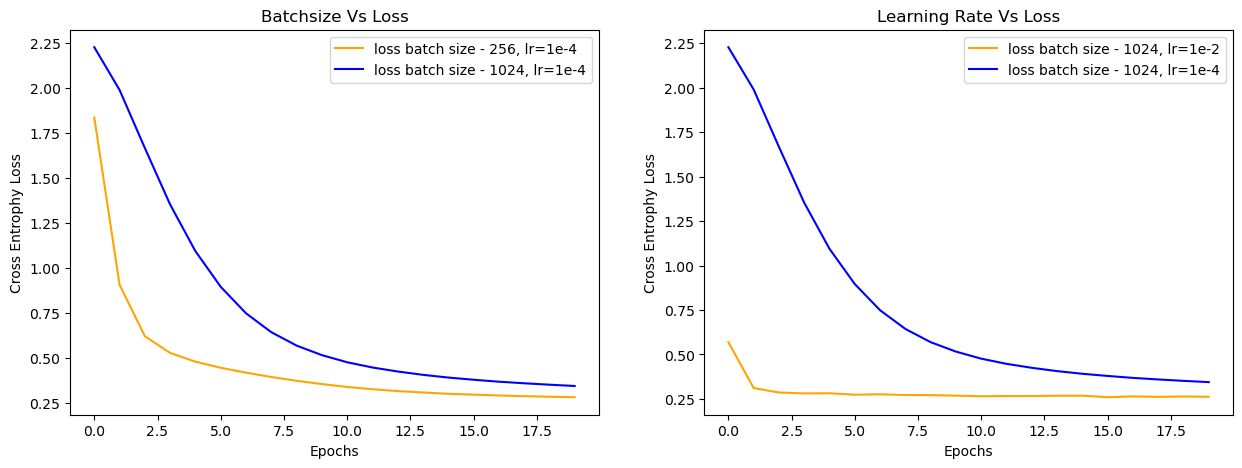

In [17]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(training_loss_lr1e4_B256, color='orange', label='loss batch size - 256, lr=1e-4')
ax1.plot(training_loss_lr1e4_B1024, color='blue', label='loss batch size - 1024, lr=1e-4')
ax1.legend()
ax1.set_title('Batchsize Vs Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross Entrophy Loss')
fig.savefig(os.path.join(path2write, 'FlatVSGen_loss_constantB.png'))

ax2 = fig.add_subplot(1,2,2)
ax2.plot(training_loss_lr1e2_B1024, color='orange', label='loss batch size - 1024, lr=1e-2')
ax2.plot(training_loss_lr1e4_B1024, color='blue', label='loss batch size - 1024, lr=1e-4')
ax2.legend()
ax2.set_title('Learning Rate Vs Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Cross Entrophy Loss')
fig.savefig(os.path.join(path2write, 'FlatVSGen_loss_constantLr.png'))

plt.show()


In [19]:
# alpha test
def inference(model, DataLoader, criterion, device=0):
  model.eval()
  valid_losses = []
  batch_iter = tqdm(enumerate(DataLoader), 'inference_loader', total=len(DataLoader), disable=False)
  batch_acc = 0
  for i, (x, y) in batch_iter:
      input, target = x.type(torch.float32).to(device), y.to(device)
      with torch.no_grad():
          output = model(input)
          target = target.type(torch.LongTensor).to(device)
          loss = criterion(output, target)
          valid_losses.append(loss.item())
          pred = output.argmax(dim=1, keepdim=True)
          batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor)).item()
  batch_iter.close()
  accuracy = batch_acc/len(DataLoader)
  loss = np.mean(valid_losses)
  return accuracy, loss

In [20]:
def alpha_test(model, model1, model2, training_DataLoader, validation_DataLoader, loss_fn):
  alphas = np.linspace(-1, 1, 10)
  train_loss = []
  train_accuracy = []
  val_loss = []
  val_accuracy = []
  model1_ = model1.state_dict()
  model2_ = model2.state_dict()
  model.to(device=0)
  for i in range(len(alphas)):
    alpha = alphas[i]
    parm_ = {}
    for key in  model1_.keys():
      parm_[key] = (1-alpha)*model1_[key] + alpha*model2_[key]
    model.load_state_dict(parm_)
    train_accuracy_, train_loss_ = inference(model, training_DataLoader, loss_fn, device=0)
    val_accuracy_, val_loss_ = inference(model, validation_DataLoader, loss_fn, device=0)
    train_loss.append(train_loss_)
    train_accuracy.append(train_accuracy_)
    val_loss.append(val_loss_)
    val_accuracy.append(val_accuracy_)
  return alphas, train_loss, train_accuracy, val_loss, val_accuracy

In [13]:
#lr constant
model = DNN()
model1 = model_lr1e4_B256
model2 = model_lr1e4_B1024
alphasB, train_lossB, train_accuracyB, val_lossB, val_accuracyB = alpha_test(model, model1, model2, training_DataLoader, validation_DataLoader, loss_fn)


inference_loader:   0%|          | 0/59 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_656613/2850139075.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
inference_loader: 100%|██████████| 10/10 [00:00<00:00, 14.48it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


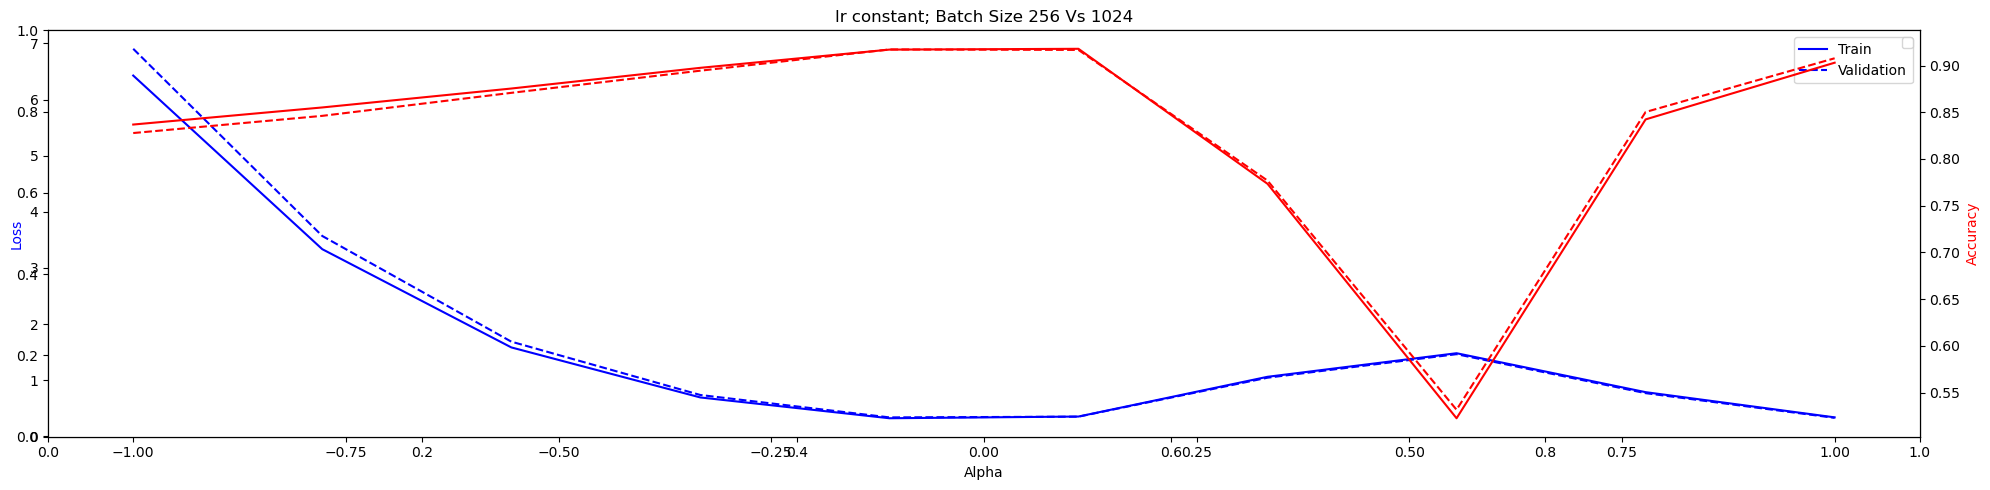

In [21]:
fig, ax1 = plt.subplots(figsize=(20, 5))

ax1 = fig.add_subplot(1,1,1)
ax1.plot(alphasB, train_lossB, 'b-', label='Train')
ax1.plot(alphasB, val_lossB, 'b--', label='Validation')
ax1.legend()
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Loss', color='b')
ax1.set_title('lr constant; Batch Size 256 Vs 1024')

ax2 = ax1.twinx()
ax2.plot(alphasB, train_accuracyB, 'r-')
ax2.plot(alphasB, val_accuracyB, 'r--')
ax2.legend()
ax2.set_ylabel('Accuracy', color='r')
fig.tight_layout()
fig.savefig(os.path.join(path2write, 'alpha_test_lr_const_Batch_256Vs1024'))
fig.show()


In [22]:
model = DNN()
model1 = model_lr1e2_B1024
model2 = model_lr1e4_B1024
alphaslr, train_losslr, train_accuracylr, val_losslr, val_accuracylr = alpha_test(model, model1, model2, training_DataLoader, validation_DataLoader, loss_fn)

inference_loader:   0%|          | 0/59 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_656613/2850139075.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
inference_loader: 100%|██████████| 10/10 [00:00<00:00, 14.37it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


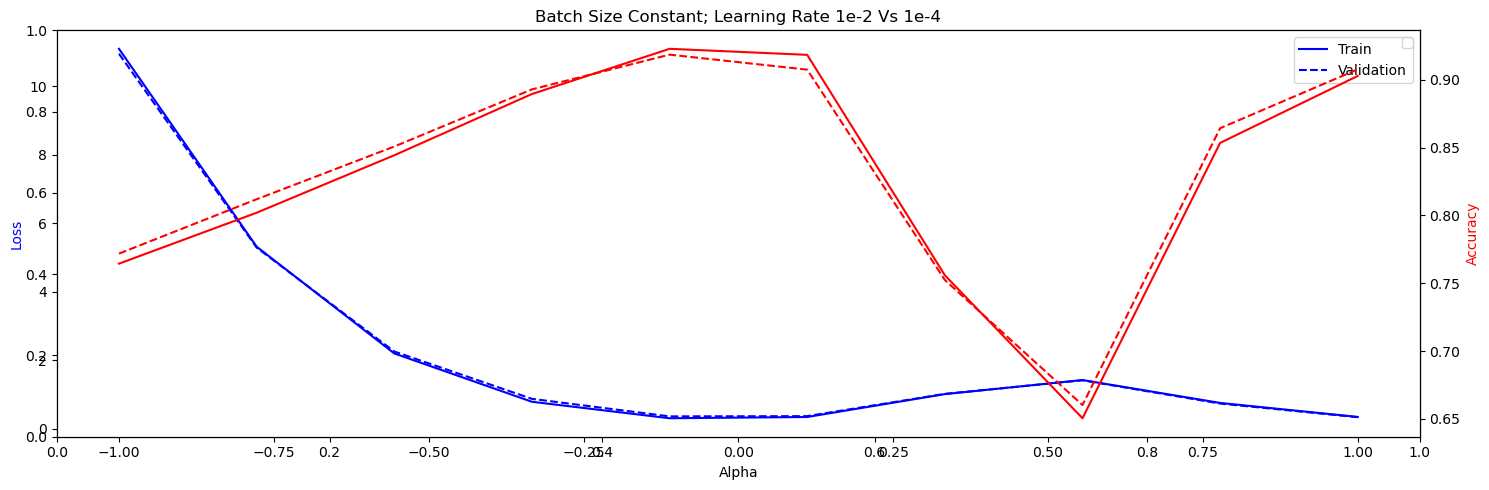

In [23]:
fig, ax1 = plt.subplots(figsize=(15, 5))

ax1 = fig.add_subplot(1,1,1)
ax1.plot(alphaslr, train_losslr, 'b-', label='Train')
ax1.plot(alphaslr, val_losslr, 'b--', label='Validation')
ax1.legend()
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Loss', color='b')
ax1.set_title('Batch Size Constant; Learning Rate 1e-2 Vs 1e-4')

ax2 = ax1.twinx()
ax2.plot(alphaslr, train_accuracylr, 'r-')
ax2.plot(alphaslr, val_accuracylr, 'r--')
ax2.legend()
ax2.set_ylabel('Accuracy', color='r')
fig.tight_layout()
fig.savefig(os.path.join(path2write, 'alpha_test_Batch_const_lr_1e-2Vs1e-4'))
fig.show()